## Load the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data():
    df_train = pd.read_csv('dataset/cleaned_train.csv')
    df_test = pd.read_csv('dataset/test.csv', encoding = "ISO-8859-1")

    return df_train, df_test

In [3]:
df_train, df_test = load_data()

In [4]:
df_train.shape

(250305, 11)

In [5]:
df_train.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

In [6]:
df_train.head()

,ticket_id,city,agency_name,violation_code,disposition,fine_amount,judgment_amount,late_fee,admin_fee,discount_amount,compliance
0,22056,4,1,1,1,250.0,305.0,25.0,20.0,0,0.0
1,27586,1,1,7,4,750.0,855.0,75.0,20.0,0,1.0
2,22062,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0
3,22084,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0
4,22093,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0


In [7]:
X = df_train[df_train.columns[1:-1]]
y = df_train['compliance']

## Resampling dataset

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [9]:
df_true = df_train[df_train.compliance == 1]
df_false = df_train[df_train.compliance != 1]

count_nopay, count_paid = df_train.compliance.value_counts()
print(count_paid, count_nopay)

11597 238708


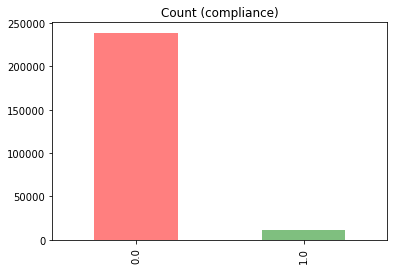

In [10]:
df_train.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Random under-sesampling

Random under-sampling:
1.0    11597
0.0    11597
Name: compliance, dtype: int64


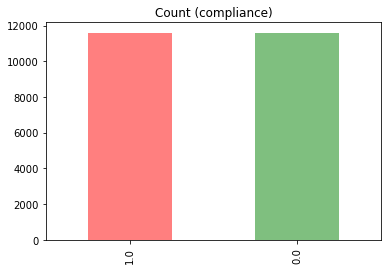

In [11]:
df_false_under = df_false.sample(count_paid)
df_train_under = pd.concat([df_false_under, df_true], axis=0)

print('Random under-sampling:')
print(df_train_under.compliance.value_counts())

df_train_under.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Random over-sesampling

Random under-sampling:
1.0    238708
0.0    238708
Name: compliance, dtype: int64


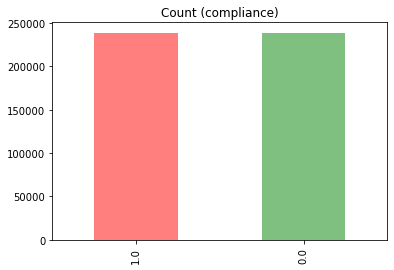

In [12]:
df_train_over = pd.concat([df_false, df_true.sample(count_nopay, replace=True)], axis=0)

print('Random under-sampling:')
print(df_train_over.compliance.value_counts())

df_train_over.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Python imblanced-learn module

In [13]:
import imblearn
print(imblearn.__version__)

0.7.0


### Random over-sampling and under-sampling with imbalanced-learn

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)

### Under-sampling: NearMiss, Edited Nearest Neighbours, OneSidedSelection, Neighbourhood Cleaning Rule

In [16]:
from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1, n_neighbors=3)
X_nm1, y_nm1 = undersample.fit_resample(X, y)

In [17]:
from imblearn.under_sampling import EditedNearestNeighbours

undersample = EditedNearestNeighbours(n_neighbors=3)
X_enn, y_enn = undersample.fit_resample(X, y)

In [18]:
from imblearn.under_sampling import OneSidedSelection

undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
X_oss, y_oss = undersample.fit_resample(X, y)

KeyboardInterrupt: 

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_ncr, y_ncr = undersample.fit_resample(X, y)

### Over-sampling: SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=0)
X_sm, y_sm = smote.fit_sample(X, y)

### Over-sampling followed by under-sampling: STMOTE and Tomek

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto', random_state=0)
X_smt, y_smt = smt.fit_sample(X, y)

### Ready for training

In [ ]:
def modelFit(X_train, X_dev, y_train, y_dev, clf, cv=5):

    clf = clf.fit(X_train, y_train)

    cv = cross_val_score(clf, X_dev, y_dev, cv=cv, scoring = 'roc_auc')
    cv_mean = round(cv.mean(), 3)
    cv_std = round(cv.std(), 3)
    print('Cross-validation (AUC)', cv, ', mean =', cv_mean, ', std =', cv_std)

    return cv_mean, cv_std

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=0, test_size=0.05)
X_train_rus, X_dev_rus, y_train_rus, y_dev_rus = train_test_split(X_rus, y_rus, random_state=0, test_size=0.05)
X_train_ros, X_dev_ros, y_train_ros, y_dev_ros = train_test_split(X_ros, y_ros, random_state=0, test_size=0.05)
X_train_nm1, X_dev_nm1, y_train_nm1, y_dev_nm1 = train_test_split(X_nm1, y_nm1, random_state=0, test_size=0.05)
X_train_enn, X_dev_enn, y_train_enn, y_dev_enn = train_test_split(X_enn, y_enn, random_state=0, test_size=0.05)
X_train_oss, X_dev_oss, y_train_oss, y_dev_oss = train_test_split(X_oss, y_oss, random_state=0, test_size=0.05)
X_train_ncr, X_dev_ncr, y_train_ncr, y_dev_ncr = train_test_split(X_ncr, y_ncr, random_state=0, test_size=0.05)
X_train_sm, X_dev_sm, y_train_sm, y_dev_sm = train_test_split(X_sm, y_sm, random_state=0, test_size=0.05)
X_train_smt, X_dev_smt, y_train_smt, y_dev_smt = train_test_split(X_smt, y_smt, random_state=0, test_size=0.05)

In [ ]:
clf_XGB = XGBClassifier()

In [ ]:
#exp0: no resampling
auc_mean_baseline, auc_std_baseline = modelFit(X_train, X_dev, y_train, y_dev, clf_XGB, cv=50)

In [ ]:
#exp1
auc_mean_ros, auc_std_ros = modelFit(X_train_ros, X_dev_ros, y_train_ros, y_dev_ros, clf_XGB, cv=50)

In [ ]:
#exp2
auc_mean_rus, auc_std_rus = modelFit(X_train_rus, X_dev_rus, y_train_rus, y_dev_rus, clf_XGB, cv=50)

In [ ]:
#exp3
auc_mean_nm1, auc_std_nm1 = modelFit(X_train_nm1, X_dev_nm1, y_train_nm1, y_dev_nm1, clf_XGB, cv=50)

In [ ]:
#exp4
auc_mean_enn, auc_std_enn = modelFit(X_train_enn, X_dev_enn, y_train_enn, y_dev_enn, clf_XGB, cv=50)

In [ ]:
#exp5
auc_mean_oss, auc_std_oss = modelFit(X_train_oss, X_dev_oss, y_train_oss, y_dev_oss, clf_XGB, cv=50)

In [ ]:
#exp6
auc_mean_ncr, auc_std_ncr = modelFit(X_train_ncr, X_dev_ncr, y_train_ncr, y_dev_ncr, clf_XGB, cv=50)

In [ ]:
#exp7
auc_mean_sm, auc_std_sm = modelFit(X_train_sm, X_dev_sm, y_train_sm, y_dev_sm, clf_XGB, cv=50)

In [ ]:
#exp8
auc_mean_smt, auc_std_smt = modelFit(X_train_smt, X_dev_smt, y_train_smt, y_dev_smt, clf_XGB, cv=50)

### Summary plot

In [ ]:
# Create lists for the plot
#exps = ['Baseline', 'RandomUnderSampler', 'RandomOverSampler', NearMiss', 'EditedNearestNeighbours', 'OneSidedSelection', 
#        'NeighbourhoodCleaningRule', 'SMOTE', 'STMOTE + Tomek']
exps = ['exp0','exp1','exp2','exp3','exp4','exp5','exp6','exp7','exp8']
x_pos = np.arange(len(exps))
CTEs = [auc_mean_baseline,auc_mean_ros,auc_mean_rus,auc_mean_nm1,auc_mean_enn,auc_mean_oss,auc_mean_ncr,auc_mean_sm,auc_mean_smt]
error = [auc_std_baseline,auc_std_ros ,auc_std_rus ,auc_std_nm1 ,auc_std_enn ,auc_std_oss ,auc_std_ncr ,auc_std_sm ,auc_std_smt]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=15)
ax.set_ylabel('Average AUC score')
ax.set_xticks(x_pos)
ax.set_xticklabels(exps)
ax.set_title('Performance of imbalanced techniques')
ax.yaxis.grid(True)
ax.set_yscale('log')

# Save the figure and show
plt.tight_layout()
plt.savefig('plots/imbalancedExp.png')
plt.show()